# Image recognition: recognizing hurricane damage

#### Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

## Introduction

This tutorial shows how to do whole image classification, or image `recognition`, starting from JPEG image files, first leveraging pre-trained weights (transfer learning)

We demonstrate the workflow on a hurricane damage dataset reported [here](https://www.kaggle.com/kmader/satellite-images-of-hurricane-damage)

Data originally taken from [here](https://ieee-dataport.org/open-access/detecting-damaged-buildings-post-hurricane-satellite-imagery-based-customized) and can be cited with [this](http://dx.doi.org/10.21227/sdad-1e56) and the original paper is [here](https://arxiv.org/abs/1807.01688)

Our trained model will be able to predict whether or not a property was damaged by a hurricane, to within 99%


## Setup

In [0]:
!pip install tf-nightly --quiet

     |████████████████████████████████| 523.4MB 32kB/s 
     |████████████████████████████████| 2.9MB 42.0MB/s 
     |████████████████████████████████| 460kB 59.7MB/s 


In [0]:
import requests, os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

tf.__version__

'2.3.0-dev20200526'

In [0]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
file_id = '1vsJU0mFlcu4QIxBPDdwuzEl_gtSS_9Gu'

destination = 'validation.zip'
download_file_from_google_drive(file_id, destination)

In [0]:
file_id = '1tlEnpQzbq-ogx3z14t12h2QH7keuTssb'

destination = 'train.zip'
download_file_from_google_drive(file_id, destination)

In [0]:
file_id = '1fawTKcBH7xTIhCoMwZtos79H6XAhBaIn'

destination = 'test.zip'
download_file_from_google_drive(file_id, destination)

In [0]:
!unzip validation.zip > tmp.txt

In [0]:
!unzip train.zip > tmp.txt

In [0]:
!unzip test.zip > tmp.txt

What class categories do I have?

In [0]:
!ls train

damage	no_damage


How many train files?

In [0]:
!ls train/damage | wc -l

5000


In [0]:
!ls train/no_damage | wc -l

5000


How many test and validation files?

In [0]:
!ls test/damage | wc -l

1000


In [0]:
!ls test/no_damage | wc -l

1000


In [0]:
!ls validation/damage | wc -l

1000


In [0]:
!ls validation/no_damage | wc -l

1000


Define text labels for our two classes

In [0]:
classes = ['damage',	'no_damage']

Get rid of any corrupt jpegs

In [0]:
num_skipped = 0
for folder in ['test', 'train', 'validation']:
  for folder_name in classes:
    folder_path = os.path.join(folder, folder_name)
    for fname in os.listdir(folder_path):
      fpath = os.path.join(folder_path, fname)
      fobj = open(fpath, 'rb')
      if tf.compat.as_bytes('JFIF') not in fobj.peek(10):
          num_skipped += 1
          # Delete corrupted image
          os.system('rm ' + fpath)
  print('Deleted %d images' % num_skipped)

Deleted 0 images
Deleted 0 images
Deleted 0 images


## Augmenting the data

In [0]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'train', seed=2020,
    image_size=image_size, batch_size=batch_size) 
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'validation',  seed=2020,
    image_size=image_size, batch_size=batch_size) 

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


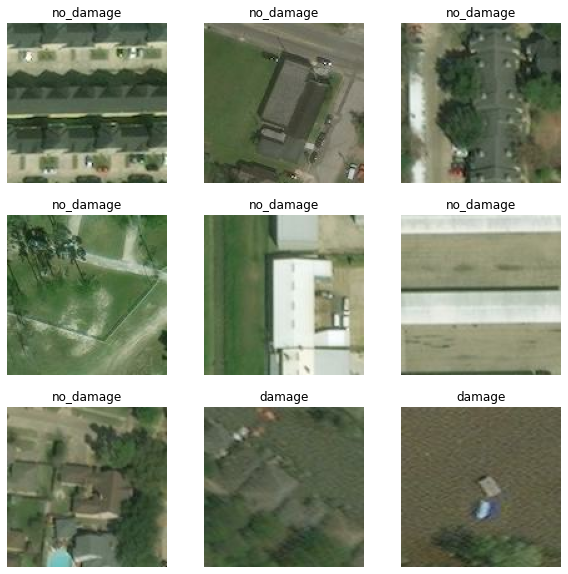

In [0]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[int(labels[i])])
    plt.axis('off')

In [0]:
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip('vertical'),
  layers.experimental.preprocessing.RandomFlip('horizontal'),
  layers.experimental.preprocessing.RandomRotation(0.3),
  layers.experimental.preprocessing.RandomZoom(0.3),
])

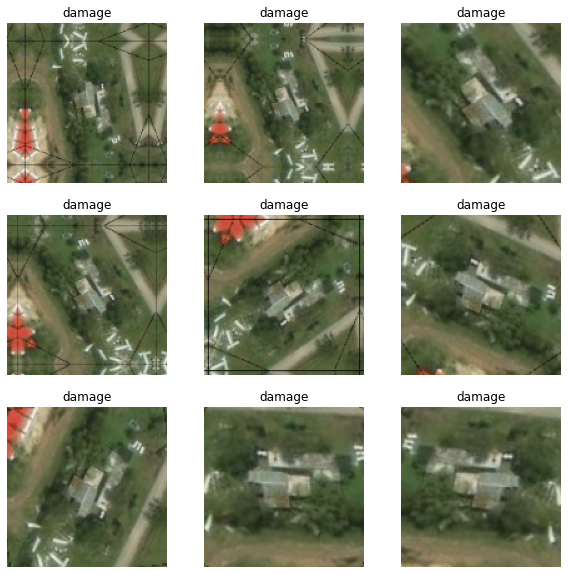

In [0]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((augmented_images[0].numpy()).astype('uint8')) #255*
    plt.title(classes[int(labels[0])])
    plt.axis('off')

Improve model throughput by using [pre-fetch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)

In [0]:
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)

In [0]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Image classification using transfer learning

### Build a model


Load the MobileNetV2 model trained on imagenet, but exclude the classification layers, because we want to add our own classification layers so we can retrain the model on our own categories

We'll use one of the 'stock' models provided by `keras.applications` called MobileNetV2

In [0]:
def mobilenet_model(num_classes, input_shape):

    EXTRACTOR = MobileNetV2(include_top=False, weights="imagenet", 
                    input_shape=input_shape)

    EXTRACTOR.trainable = True
    # Construct the head of the model that will be placed on top of the
    # the base model
    class_head = EXTRACTOR.output
    class_head = layers.GlobalAveragePooling2D()(class_head)
    class_head = layers.Dense(512, activation="relu")(class_head)
    class_head = layers.Dropout(0.5)(class_head)
    class_head = layers.Dense(num_classes, activation="softmax")(class_head)

    # Create the new model
    model = keras.Model(inputs=EXTRACTOR.input, outputs=class_head)

    return model

### Train the model

In [0]:
min_lr = 1e-4
patience = 5
factor = 0.8
cooldown = 3

epochs = 50

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [0]:
filepath = 'hurricanes_mn2_best_weights.h5'

In [0]:
earlystop = EarlyStopping(monitor="val_loss", 
                              mode="min", patience=patience) 

# reduction of learning rate if and when validation scores plateau upon successive epochs
reduceloss_plat = ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=patience, 
                                verbose=1, mode='auto', 
                                cooldown=cooldown, min_lr=min_lr)

# set checkpoint file 
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                                verbose=0, save_best_only=True, mode='min', 
                                save_weights_only = True)
    
callbacks = [model_checkpoint, reduceloss_plat, earlystop]

In [0]:
from tensorflow.keras.applications import MobileNetV2

input_shape = (224, 224)

model2 = mobilenet_model(len(classes), input_shape+(3,) )

model2.compile(optimizer=keras.optimizers.Adam(min_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
model2.fit_generator(augmented_train_ds, 
                   validation_data=val_ds, 
                   epochs=50,
                   verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
313/313 - 47s - loss: 0.3056 - accuracy: 0.8706 - val_loss: 2.7860 - val_accuracy: 0.5150
Epoch 2/50
313/313 - 46s - loss: 0.1573 - accuracy: 0.9340 - val_loss: 0.2622 - val_accuracy: 0.9045
Epoch 3/50
313/313 - 47s - loss: 0.1177 - accuracy: 0.9509 - val_loss: 0.1398 - val_accuracy: 0.9375
Epoch 4/50
313/313 - 46s - loss: 0.0992 - accuracy: 0.9592 - val_loss: 0.0946 - val_accuracy: 0.9590
Epoch 5/50
313/313 - 46s - loss: 0.0836 - accuracy: 0.9671 - val_loss: 0.0814 - val_accuracy: 0.9675
Epoch 6/50
313/313 - 47s - loss: 0.0758 - accuracy: 0.9721 - val_loss: 0.0650 - val_accuracy: 0.9735
Epoch 7/50
313/313 - 47s - loss: 0.0642 - accuracy: 0.9756 - val_loss: 0.0678 - val_accuracy: 0.9755
Epoch 8/50
313/313 - 47s - loss: 0.0514 - accuracy: 0.9791 - val_loss: 0.0742 - val_accuracy: 0.9730
Epoch 9/50
313/313 - 47s - loss: 0.0523 - accuracy: 0.9793 - val_loss: 0.0690 - val_accuracy: 0.9725
Epoch 10/50
313

### Run inference on new data

Dropout are inactive at inference time, so that layer won't affect our model results

In [0]:
f = glob('test/no_damage/*.jpeg')[0]

img = keras.preprocessing.image.load_img(f, target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
scores = model2.predict(img_array).flatten()
print(classes[np.argmax(scores)])

no_damage


We can use the `model.evaluate()` function to evaluate the average accuracy for the entire test set

In [0]:
scores = model2.evaluate(val_ds)

2000/2000 [==============================] - 11s 5ms/step - loss: 0.0223 - accuracy: 0.9920


### Plotting the confusion matrix

The confusion matrix is one of correspondences between actual and predicted labels, per class

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Get a new validation batch generator with a batch size of 1, and shuffling set to False because we want to pair each image with its class

In [0]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'test',  seed=2020, shuffle=False,
    image_size=image_size, batch_size=1)

Found 2000 files belonging to 2 classes.


Get the image class labels and store in a list `L`

In [0]:
L = []
for _, labels in val_ds:
  L.append(int(labels[0]))

In [0]:
np.bincount(L)

array([1000, 1000])

Use the trained model to make predictions on the test set

In [0]:
preds = model2.predict(val_ds)
pred = np.argmax(preds, axis=1)

Get the confusion matrix (the matrix of label correspondences between ground truth and model prediction)

In [0]:
cm = confusion_matrix(np.asarray(L), pred)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Make a plot of that matrix

([<matplotlib.axis.YTick at 0x7f85546ec4e0>,
 [Text(0, 0.5, 'damage'), Text(0, 1.5, 'no_damage')])

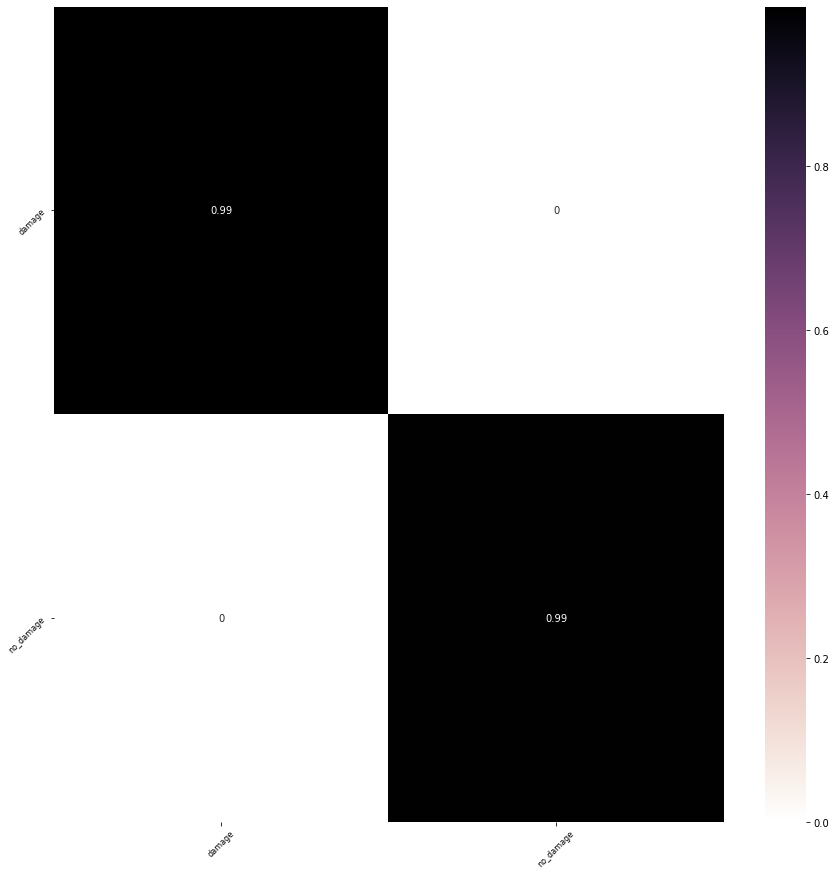

In [0]:
plt.figure(figsize=(15,15))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True)) 
    
tick_marks = np.arange(len(classes))+.5
plt.xticks(tick_marks, classes, rotation=45,fontsize=10)
plt.yticks(tick_marks, classes,rotation=45, fontsize=10)	

Both classes are estimated to within 1%